In [232]:
# install packages
import numpy as np
import pandas as pd
import sys
import sklearn
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
np.set_printoptions(threshold=sys.maxsize)

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,train_test_split, StratifiedKFold

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import missingno as msno

# pre-process
from sklearn import preprocessing as prep
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer

from sklearn.neighbors import LocalOutlierFactor

import imblearn
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE

from sklearn.pipeline import Pipeline,make_pipeline
# from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,IsolationForest
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import scipy
from scipy.stats import uniform, randint,truncnorm

# evaluate
from sklearn.metrics import classification_report,roc_curve,roc_auc_score,confusion_matrix,recall_score,average_precision_score, plot_precision_recall_curve


import warnings
warnings.filterwarnings("ignore")

In [233]:
# import data
missing_values=['.','NA','-','n/a','na']
train= pd.read_csv('aug_train.csv',
                    na_values=missing_values)

test= pd.read_csv('aug_test.csv',
                  na_values=missing_values)


target = train['target']
train = train.drop(['target'],axis=1)

# train test split
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.10, random_state=42)

In [234]:
# EDA
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17242 entries, 9016 to 15795
Data columns (total 13 columns):
enrollee_id               17242 non-null int64
city                      17242 non-null object
city_development_index    17242 non-null float64
gender                    13157 non-null object
relevent_experience       17242 non-null object
enrolled_university       16893 non-null object
education_level           16821 non-null object
major_discipline          14708 non-null object
experience                17182 non-null object
company_size              11874 non-null object
company_type              11686 non-null object
last_new_job              16868 non-null object
training_hours            17242 non-null int64
dtypes: float64(1), int64(2), object(10)
memory usage: 1.8+ MB


In [235]:
X_train.head(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
9016,45,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,1000-4999,Public Sector,>4,26
7677,17575,city_65,0.802,Male,No relevent experience,no_enrollment,Graduate,Arts,11,50-99,Pvt Ltd,>4,48
9541,204,city_160,0.920,Male,Has relevent experience,Full time course,High School,NaN,3,10000+,Pvt Ltd,1,23
15429,27612,city_21,0.624,NaN,No relevent experience,NaN,High School,NaN,2,NaN,NaN,never,43
14312,27937,city_103,0.920,Other,No relevent experience,no_enrollment,Graduate,STEM,16,10000+,NGO,>4,6


In [236]:
####### Feature Engineering#######
#######1. Encode categorical variables into numerical variables#########
# step 1: find all qualitative/categorical variables
categorical_vars = [col for col in X_train.columns if X_train[col].dtypes == 'O']
categorical_vars

['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [237]:
# step 2: categorical variables can be categorized as ordinal and non ordinal variables.
# Split them since we would use different encoding methods.
ordinal_vars = ['last_new_job','education_level', 'experience','company_size','city']
# non-oridinal variables can be further specified as nominal and binary variables
non_ordinal = ['gender','enrolled_university','major_discipline','company_type','relevent_experience']

In [238]:
# step 3: Encode ordinal variables by LabelEncoder, non-ordinal variables by OneHotEncoder
class cat_encode():
    '''
    Encode categorical features into numeric numbers.
    '''
    def __init__(self, dtype='ordinal'):
        self.dtype = dtype

    def fit(self, X,y=None):
        return self 

    def transform(self, X,y=None):
        if self.dtype == 'ordinal':
            X[ordinal_vars] = X[ordinal_vars].apply(LabelEncoder().fit_transform)
            
        elif self.dtype == 'non_ordinal':
            ohe = OneHotEncoder(sparse=False, drop='first')
            missing_non_ordinal = X[non_ordinal].fillna('missing')
            non_ord_df = ohe.fit_transform(missing_non_ordinal)
            X_nonord = pd.DataFrame(non_ord_df,columns=ohe.get_feature_names(['gender','enrolled_university','major_discipline','company_type','last_new_job']))
            
            X = X.reset_index(drop=True)
            X = pd.concat([X, X_nonord],axis=1)
            X.drop(non_ordinal,axis=1,inplace=True)
        
        return X

In [239]:
cat_transformer = Pipeline(
    [
        ('ceo',cat_encode('ordinal')),
        ('ceno',cat_encode('non_ordinal'))
    ]
)

In [240]:
####### Feature Engineering#######
####### 2. Handle missing vals #########
class df_imputer(BaseEstimator, TransformerMixin):
    '''
    Just a wrapper for the KNNImputer that fill in the missing values.
    '''
    def __init__(self):
        self.imputer = KNNImputer(n_neighbors=100)

    def fit(self,X,y=None):
        return self
 
    def fillnan(self,X,col):
        
        """
        For OHE, I create a seperate missing indicator column. 
        For those rows with missingness, replace 0 with nan.
        """

        # extract the prefix of the missing indicator column
        prefix = col.split('_')[0]
        # look for all the columns with that prefix
        prefixcols = [col for col in X.columns if col.startswith(prefix)]
        # remove the missing indicatore column from the list
        prefixcols.remove(col)
        # with index known, locate the value and change it to np.nan
        for prefixcol in prefixcols:
            X.loc[X[col]==1, prefixcol] = np.nan
    
    def preprocess(self,X):
        missing_cols = [col for col in X.columns if 'missing' in col]
        
        for missing_col in missing_cols:
            self.fillnan(X=X,col=missing_col)
        
        # delete the missing indicator column.
        X.drop(missing_cols, axis = 1,inplace=True)
        
        
    def transform(self, X,y=None):        
        self.preprocess(X)
        self.imputer.fit(X)
        # fit KNNImputer
        knn_array = np.round(self.imputer.transform(X))    
        X = pd.DataFrame(knn_array, columns = X.columns)
    
        return X


In [241]:
# ####### Feature Engineering#######
# ####### 3. Anomaly Detection #########
# class handle_outliers():
#     '''
#     Detect outliers and remove those points.
#     '''
#     def __init__(self):
#         self.lof = LocalOutlierFactor(n_neighbors=30)
        
        
#     def fit(self,X,y=None):
#         self.lof.fit(X)
#         return self
    
    
#     def transform(self,X,y=None):
#         # identify outliers in the training dataset
#         yhat = self.lof.fit_predict(X)

#         # convert yhat to a datefarme
#         yhat = pd.DataFrame(yhat,columns = ['target'])

#         # find indices with yhat == -1 (outlier)
#         outlier_indices = yhat[yhat.target == -1].index.values.tolist()
        
#         # update X_train & y_train, delete rows with those indecs
#         X = X.drop(outlier_indices)
        
# #         y.reset_index(drop=True,inplace=True)       
# #         y = y.drop(outlier_indices)
        
#         return X

In [242]:
####### Feature Engineering#######
####### 3. Anomaly Detection #########
class handle_outliers():
    '''
    Detect outliers and remove those points.
    '''
    def __init__(self):
        self.iforest = IsolationForest(contamination = 0.1)
        
        
    def fit(self,X,y=None):
        self.iforest.fit(X)
        return self
    
    
    def transform(self,X,y=None):
        # identify outliers in the training dataset
        yhat = self.iforest.fit_predict(X)

        # convert yhat to a datefarme
        yhat = pd.DataFrame(yhat,columns = ['target'])

        # find indices with yhat == -1 (outlier)
        outlier_indices = yhat[yhat.target == -1].index.values.tolist()
        
        print("There are %f of outliers",len(outlier_indices))
        # update X_train & y_train, delete rows with those indecs
        X = X.drop(outlier_indices)
        
        return X

In [243]:
# STEP 2: over-sample using SMOTE(Synthetic Minority Oversampling Technique)
class oversample():
    def _init_(self):
        pass
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        sm = SMOTE(sampling_strategy='minority',k_neighbors=4,random_state=42)
        X_features = X.drop(['target'],axis=1)
        X_target = X['target']
        X_features,X_target = sm.fit_resample(X_features,X_target)
        
        X = pd.concat([X_features, X_target],axis=1)
        return X

<AxesSubplot:xlabel='target', ylabel='count'>

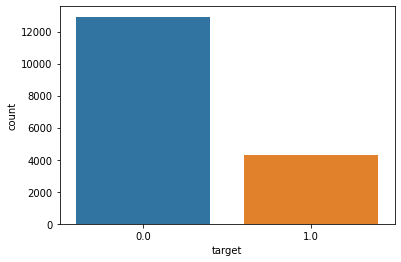

In [244]:
####### Feature Engineering#######
####### 4. Handle imblanced dataset #########
# STPE 1: check if the dataset is balanced
y_cnt=y_train.value_counts().reset_index()
y_cnt.columns = ['target','count']
sns.barplot(x="target",y="count",data=y_cnt)
# We can see the data is highly imbalanced.

In [245]:
# STEP 2: over-sample using SMOTE(Synthetic Minority Oversampling Technique)
class std_scaler():
    def _init_(self):
        pass
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        th_train = X[['training_hours']]
        scaler = StandardScaler().fit(th_train)
        X_scaled = scaler.transform(th_train)
        X['training_hours'] = pd.DataFrame(X_scaled,columns=['training_hours'])
        return X

In [246]:
####### Feature Engineering#######
####### 5. Feature Selection #########
class feat_sel():
    def __init__(self):
        self.feat_importances = 0
        
    def fit(self,X,y=None):
        return self
        
    def transform(self,X,y=None):
        # calculate feature importances
        model = ExtraTreesClassifier()
        
        X_features = X.drop(['target'],axis=1)
        X_target = X['target']
        model.fit(X_features,X_target)
        
        self.feat_importances = pd.Series(model.feature_importances_, index=X_features.columns)
        
        # plot feature importance in order
        self.feat_importances.nlargest(20).plot(kind='barh')
        plt.show()
        
        # if feature importance is below a certain threshold, we choose to drop it.
        fi = pd.DataFrame(model.feature_importances_,index=X_features.columns)
        fi.reset_index(inplace=True)
        fi.columns = ['feature', 'score']
        fi = fi.sort_values(by='score', ascending=False)
        
        # set 0.005 as threshold
        feature_list = fi[fi['score'] > 0.01].feature.tolist()
        X = pd.concat([X_features[feature_list],X_target],axis=1)
        
        return X

In [247]:
####### Feature Engineering#######
####### 6. Dimensional Reduction #########
# STEP 1: draw corrlation matrix to see if dimensional reduction is needed
class draw_cm():
    def _init_():
        pass
    def draw(self,X,y):
        #get correlations of each features in dataset
        data = pd.concat([X,y])
        corrmat = data.corr()
        top_corr_features = corrmat.index
        plt.figure(figsize=(25,25))
        #plot heat map
        g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [277]:
# make pipeline for pre-process data
full_pipe = sklearn.pipeline.Pipeline(
    [
        ('cat_transformer',cat_transformer),
        ('imputer',df_imputer()),
        ('scaler',std_scaler()),
        ('handle_outliers',handle_outliers()),
        ('oversample',oversample()),
#         ('fs', feat_sel())
    ]
)

In [278]:
# pre-process train set
train_tmp = pd.concat([X_train,y_train],axis=1)
train_tmp = full_pipe.fit_transform(train_tmp)
train_tmp

There are %f of outliers 1725


,enrollee_id,city,city_development_index,education_level,experience,company_size,last_new_job,training_hours,gender_Male,gender_Other,enrolled_university_Part time course,enrolled_university_no_enrollment,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_No relevent experience,target
0,45.000000,5.000000,1.000000,0.000000,21.000000,2.000000,4.000000,-0.655862,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
1,17575.000000,94.000000,1.000000,0.000000,2.000000,4.000000,4.000000,-0.288267,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0
2,204.000000,49.000000,1.000000,1.000000,13.000000,3.000000,0.000000,-0.705989,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
3,27612.000000,64.000000,1.000000,1.000000,11.000000,3.000000,5.000000,-0.371812,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0
4,32078.000000,5.000000,1.000000,0.000000,14.000000,4.000000,2.000000,-0.705989,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,2105.000000,64.000000,1.000000,2.000000,4.000000,1.000000,1.000000,0.597303,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0
6,20204.000000,49.000000,1.000000,1.000000,21.000000,7.000000,4.000000,1.583126,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
7,3735.000000,5.000000,1.000000,0.000000,21.000000,7.000000,4.000000,-0.488774,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
8,8611.000000,5.000000,1.000000,0.000000,21.000000,5.000000,4.000000,2.050975,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0
9,3641.000000,5.000000,1.000000,0.000000,21.000000,1.000000,2.000000,2.117810,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0


In [252]:
train_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23610 entries, 0 to 23609
Data columns (total 24 columns):
enrollee_id                             23610 non-null float64
city                                    23610 non-null float64
city_development_index                  23610 non-null float64
education_level                         23610 non-null float64
experience                              23610 non-null float64
company_size                            23610 non-null float64
last_new_job                            23610 non-null float64
training_hours                          23610 non-null float64
gender_Male                             23610 non-null float64
gender_Other                            23610 non-null float64
enrolled_university_Part time course    23610 non-null float64
enrolled_university_no_enrollment       23610 non-null float64
major_discipline_Business Degree        23610 non-null float64
major_discipline_Humanities             23610 non-null float64
major_dis

In [253]:
# pre-process test set
# test_tmp = pd.concat([X_test,y_test],axis=1)
# test_tmp = test_pipe.fit_transform(test_tmp)
# test_tmp

In [279]:
# pre-process the actual set

# STEP 1 : prepare the dateset
actual_test_tmp =test.copy()
# randomly set target to 0/1, will be removed later.
actual_test_tmp['target'] = np.random.randint(0, 2, actual_test_tmp.shape[0])

# STEP 2: create pre-processing pipeline
test_pipe = sklearn.pipeline.Pipeline(
    [
        ('cat_transformer',cat_transformer),
        ('imputer',df_imputer()),
        ('scaler',std_scaler()),
    ]
)
actual_test_tmp = test_pipe.fit_transform(actual_test_tmp)

# STEP 3: manually drop features having low feature importance
feature_list = train_tmp.columns.tolist()
actual_test_tmp = actual_test_tmp[feature_list]
actual_test_tmp.drop(['target','enrollee_id'],axis=1,inplace=True)
actual_test_tmp.head(5)

,city,city_development_index,education_level,experience,company_size,last_new_job,training_hours,gender_Male,gender_Other,enrolled_university_Part time course,enrolled_university_no_enrollment,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_No relevent experience
0,69.0,1.0,0.0,19.0,3.0,0.0,-0.730319,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5.0,1.0,0.0,15.0,8.0,0.0,0.548230,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,55.0,1.0,1.0,20.0,8.0,5.0,-0.829946,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,22.0,1.0,2.0,2.0,0.0,0.0,-0.431437,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5.0,1.0,0.0,21.0,3.0,4.0,0.116513,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [255]:
actual_test_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 22 columns):
city                                    2129 non-null float64
city_development_index                  2129 non-null float64
education_level                         2129 non-null float64
experience                              2129 non-null float64
company_size                            2129 non-null float64
last_new_job                            2129 non-null float64
training_hours                          2129 non-null float64
gender_Male                             2129 non-null float64
gender_Other                            2129 non-null float64
enrolled_university_Part time course    2129 non-null float64
enrolled_university_no_enrollment       2129 non-null float64
major_discipline_Business Degree        2129 non-null float64
major_discipline_Humanities             2129 non-null float64
major_discipline_No Major               2129 non-null float64
major_discipline_Other   

In [280]:
####### Modelling #######
#######  #########

# 1. Prepare dataset
    # import actual target value
    # split features & target in train set
y_target_val = np.load("jobchange_test_target_values.npy")

X_train_tmp = train_tmp.drop(['target','enrollee_id'],axis=1)
y_train_tmp = train_tmp['target']

X_train_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23510 entries, 0 to 23509
Data columns (total 22 columns):
city                                    23510 non-null float64
city_development_index                  23510 non-null float64
education_level                         23510 non-null float64
experience                              23510 non-null float64
company_size                            23510 non-null float64
last_new_job                            23510 non-null float64
training_hours                          23510 non-null float64
gender_Male                             23510 non-null float64
gender_Other                            23510 non-null float64
enrolled_university_Part time course    23510 non-null float64
enrolled_university_no_enrollment       23510 non-null float64
major_discipline_Business Degree        23510 non-null float64
major_discipline_Humanities             23510 non-null float64
major_discipline_No Major               23510 non-null float64
major_dis

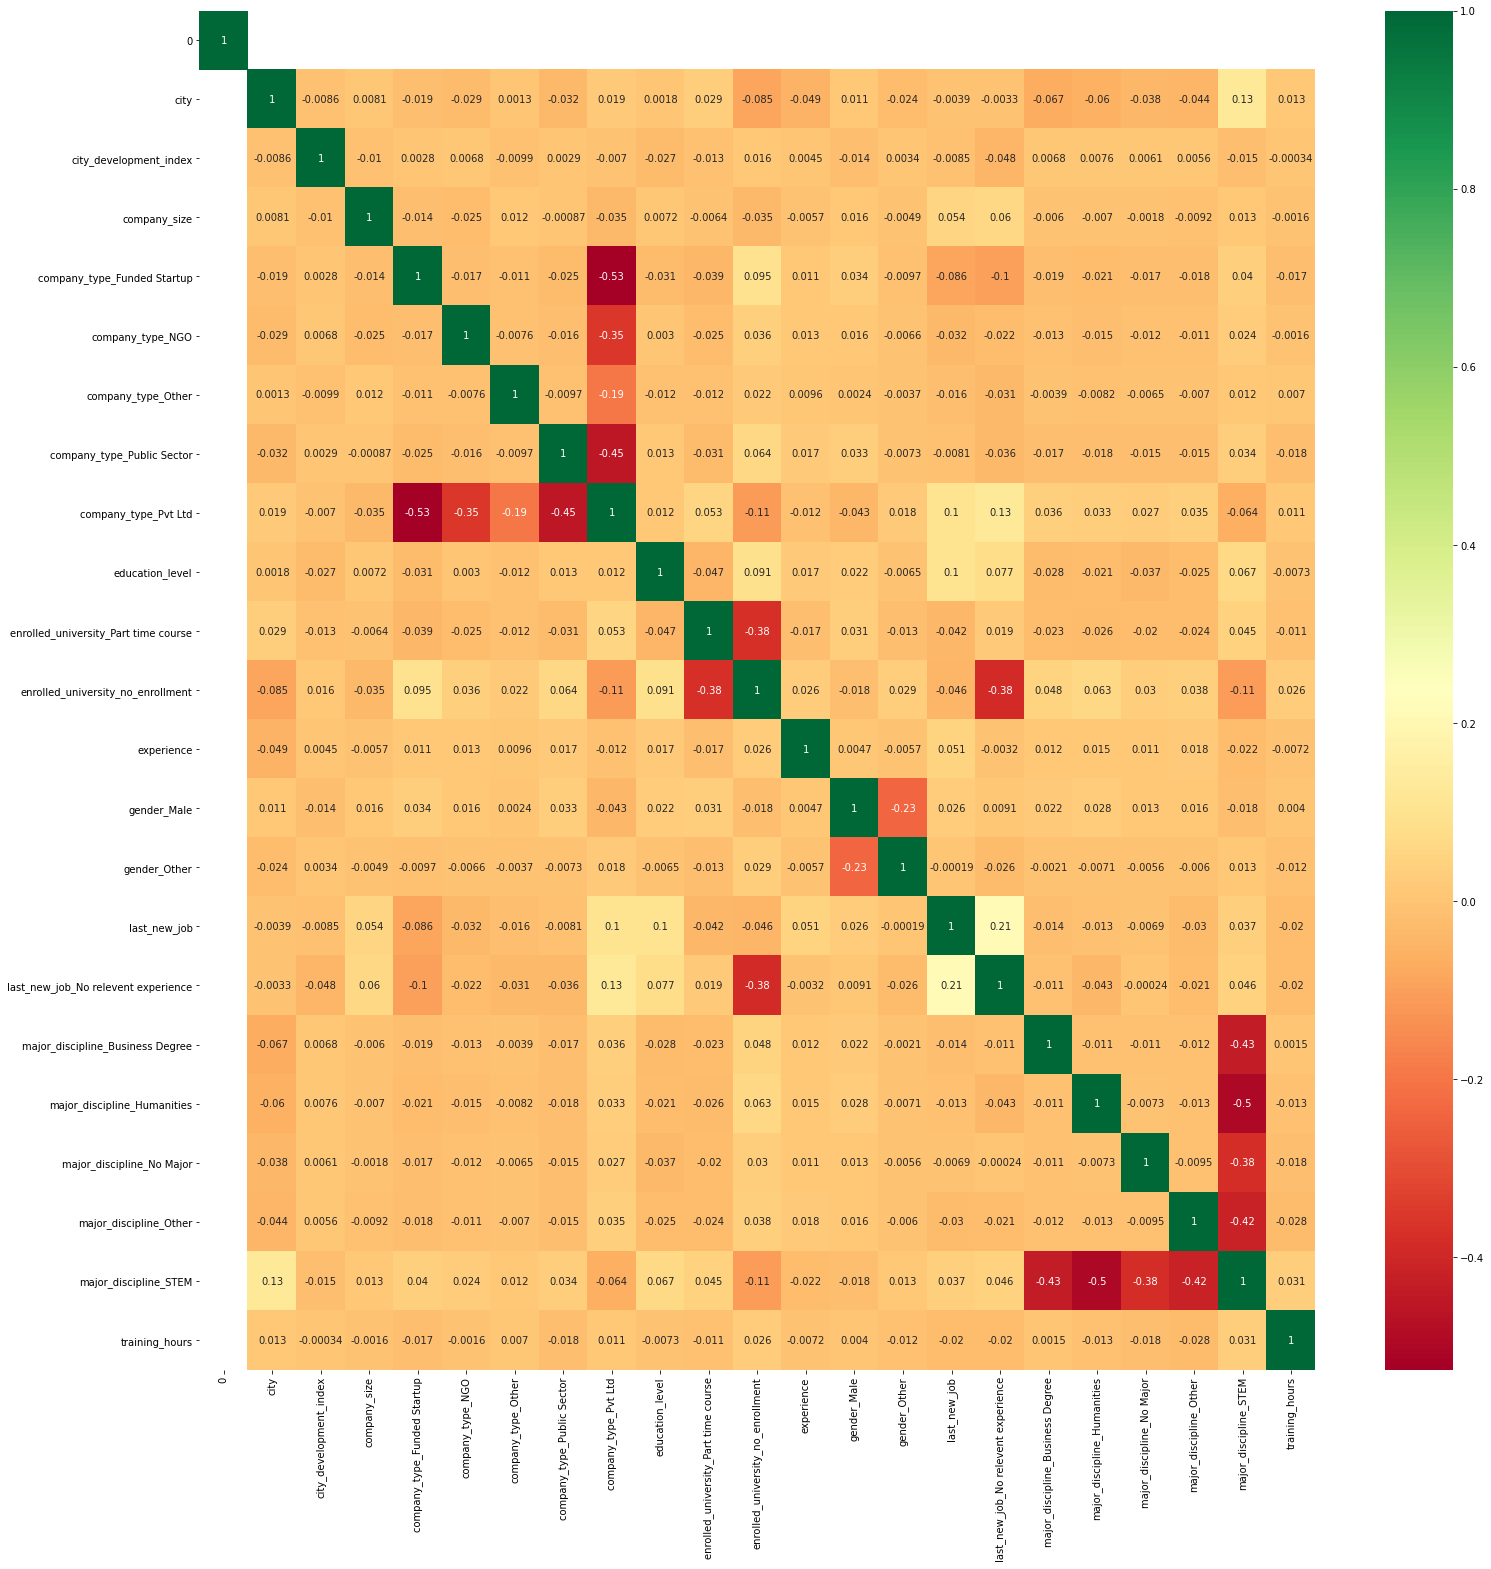

In [352]:
draw_cm().draw(X_train_tmp,y_train_tmp)

In [ ]:
# STEP 2: 
#   we can see most of the correlation coefficients < 0.3, so we don't need reduce the dimension.

In [258]:
# X_test_tmp = test_tmp.drop(['target'],axis=1)
# # X_test_tmp = X_test_tmp[feature_list]
# y_test_tmp = test_tmp['target']
# feature_list = X_train_tmp.columns
# X_test_tmp = X_test_tmp[feature_list]
# X_test_tmp.info()

In [300]:
# 2. initiate params & models
# weights = np.linspace(0.05, 0.95, 30)

rf_params = {
#     'clf__class_weight': [{0: x, 1: 1.0-x} for x in weights],
    'RandomForestClassifier__max_depth':[5,15,30,35],
    'RandomForestClassifier__n_estimators': [80,100],
    'RandomForestClassifier__max_features':[1,2,5],
    'RandomForestClassifier__min_samples_leaf':[2,5,10]
}


knn_params = {
    'KNeighborsClassifier__n_neighbors':[5,10,20,40],
    'KNeighborsClassifier__weights':['uniform','distance']
}

gbst_params = { 
    'GradientBoostingClassifier__loss':['deviance'],
    'GradientBoostingClassifier__n_estimators': [3,5,10], 
    'GradientBoostingClassifier__learning_rate': [0.1,0.3, 0.5, 0.6,0.8],
    'GradientBoostingClassifier__random_state':[42],
    'GradientBoostingClassifier__min_samples_leaf':[50,70,100],
    'GradientBoostingClassifier__max_depth':[2,3,5,6,7,8],
}


xgb_params = {
#      'clf__class_weight': [{0: x, 1: 1.0-x} for x in weights],
    'XGBClassifier__eta': [0.01],
    'XGBClassifier__max_depth' : [10,15,20],
    'XGBClassifier__min_child_weight' : [1,3,5],
    'XGBClassifier__reg_alpha' :[9,11],
    'XGBClassifier__reg_lambda':[9,11],
    'XGBClassifier__n_estimators':[20,27,30],
    'XGBClassifier__max_delta_step':[1,2,3]
}

In [260]:
def Find_Optimal_Cutoff(y_true, y_score):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    """
    
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    i = np.arange(len(tpr)) 
    # we wanna find the threshold that maximize (tpr-fpr)
    roc = pd.DataFrame({'tf' : pd.Series(tpr-fpr, index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_optimal_threshold = roc.iloc[(roc.tf).argmax()]['threshold']

    return roc_optimal_threshold

In [328]:
def print_evaluation_metrics(y_true,y_pred,y_pred_proba):
    """
    Print classification report and confusion matric of the predict val
    """
    print(confusion_matrix(y_true,y_pred))
    print(classification_report(y_true,y_pred))
    print("PR AUC score:",average_precision_score(y_true, y_pred_proba))

In [331]:
%%time
names = [
         "RandomForestClassifier",
         "KNeighborsClassifier",
         "GradientBoostingClassifier",
         "XGBClassifier"
]

classifiers = [
    RandomForestClassifier(),
    KNeighborsClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier()
]

parameters = [
    rf_params,
    knn_params,
    gbst_params,
    xgb_params
]


f1_list = {}

for name, classifier, params in zip(names, classifiers, parameters):

    clf_pipe = sklearn.pipeline.Pipeline([
            (name,classifier)
    ])

    gs_clf = RandomizedSearchCV(clf_pipe,params,n_iter=130, n_jobs=-1,scoring='f1',cv=3)
    clf = gs_clf.fit(X_train_tmp, y_train_tmp)

    y_train_pred = clf.predict(X_train_tmp)
    y_train_proba = clf.predict_proba(X_train_tmp)[:,1]

    # summarize results of train set
    print("########################### result of train set ######################################################")

    print(clf.best_estimator_)
    print_evaluation_metrics(y_train_tmp,y_train_pred,y_train_proba)

        # summarize results of test set
    #     print("########################### result of test set ######################################################")

    #     y_test_pred = gs_clf.predict(X_test_tmp)
    #     print_evaluation_metrics(y_test_tmp,y_test_pred)

    #     print("########################### result of test set after setting optimal threshold######################################################")  
    #     X_test_tmp["y_test_prob"] = gs_clf.predict_proba(X_test_tmp)[:,1]

    #     test_threshold = Find_Optimal_Cutoff(y_test_tmp, X_test_tmp["y_test_prob"])
    #     print ("the threshold is ",test_threshold)

    #     y_test_pred = X_test_tmp["y_test_prob"].map(lambda x: 1 if x > threshold else 0)

    #     print_evaluation_metrics(y_test_tmp,y_test_pred)


    #     y_pred = gs_clf.predict(X_test_tmp)

        # compare the predicted target val(pred) with the actual val(y_target_val)
        # evaluation metrics: classification_repot, AUC_ROC
    #     print("Below is the classification report of %s on test set" % (name))
    #     print(classification_report(y_test_tmp, y_pred))


    print("########################### result of actual set ######################################################")

    actual_pred = gs_clf.predict(actual_test_tmp)
    actual_pred_prob = gs_clf.predict_proba(actual_test_tmp)[:,1]

    # Print evluation metrics
    print_evaluation_metrics(y_target_val,actual_pred,actual_pred_prob)
    
    # add all f1 scores to a dict for later visualization
    train_report = classification_report(y_target_val,actual_pred,output_dict=True)
    f1_list[name] = train_report['1.0']['f1-score']
    

    print("########################### predict the actual set after setting optimal threshold ######################################################")

    # Add prediction probability to dataframe
    #     actual_test_tmp['pred_proba'] = gs_clf.predict_proba(actual_test_tmp)[:,1]
    pred_proba = gs_clf.predict_proba(actual_test_tmp)[:,1]
    pred_proba = pd.DataFrame(pred_proba)

    # Find optimal probability threshold
    threshold = Find_Optimal_Cutoff(y_target_val,pred_proba)
    print ("the optimal threshold is ",threshold)

    # Find prediction to the dataframe applying threshold
    pred = pred_proba.applymap(lambda x: 1 if x > threshold else 0)

    # Print evluation metrics
    print_evaluation_metrics(y_target_val,pred,pred_proba)
    
    # add all f1 scores to a dict for later visualization
    new_name = name + 'threshold'
    train_report = classification_report(y_target_val,pred,output_dict=True)
    f1_list[new_name] = train_report['1.0']['f1-score']

########################### result of train set ######################################################
Pipeline(steps=[('RandomForestClassifier',
                 RandomForestClassifier(max_depth=5, max_features=1,
                                        min_samples_leaf=10,
                                        n_estimators=80))])
[[8726 3029]
 [2731 9024]]
              precision    recall  f1-score   support

         0.0       0.76      0.74      0.75     11755
         1.0       0.75      0.77      0.76     11755

    accuracy                           0.75     23510
   macro avg       0.76      0.75      0.75     23510
weighted avg       0.76      0.75      0.75     23510

PR AUC score: 0.8429498874430887
########################### result of actual set ######################################################
[[1205  348]
 [ 314  262]]
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.78      1553
         1.0       0.43      0.45    

In [332]:
f1_list

{'RandomForestClassifier': 0.44182124789207416,
 'RandomForestClassifierthreshold': 0.45817633760361726,
 'KNeighborsClassifier': 0.4376828554710357,
 'KNeighborsClassifierthreshold': 0.34499593165174935,
 'GradientBoostingClassifier': 0.4108108108108108,
 'GradientBoostingClassifierthreshold': 0.49964813511611544,
 'XGBClassifier': 0.3825887743413517,
 'XGBClassifierthreshold': 0.5164003364171573}

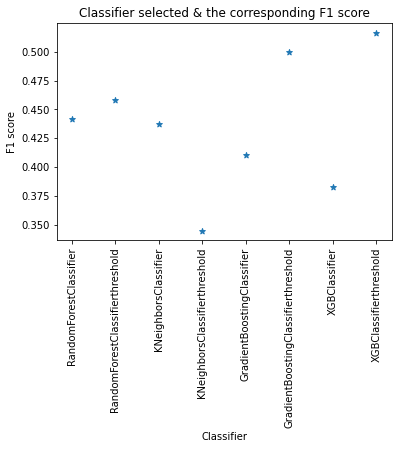

In [351]:
plt.title(u'Classifier selected & the corresponding F1 score')

plt.xlabel('Classifier')
plt.ylabel('F1 score')

plt.scatter(*zip(*f1_list.items()),marker='*')
plt.xticks(color='black',rotation=90)
plt.show()